# Cost Prediction for Logistic Company

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

Questions to consider:

- Who are your stakeholders?
    - Shippers and recievers 
- What are your stakeholders' pain points related to this project?
    - 
- Why are your predictions important from a business perspective?
    - The predictions are important 
- What exactly is your deliverable: your analysis, or the model itself?
    - 
- Does your business understanding/stakeholder require a specific type of model?
    - 
    - For example: a highly regulated industry would require a very transparent/simple/interpretable model, whereas a situation where the model itself is your deliverable would likely benefit from a more complex and thus stronger model
Additional questions to consider for classification:

- What does a false positive look like in this context?
- What does a false negative look like in this context?
- Which is worse for your stakeholder?
- What metric are you focusing on optimizing, given the answers to the above questions?

## Imports

In [772]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm 

from datetime import datetime
from time import strftime

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_predict, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder,  MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, recall_score, accuracy_score, classification_report

## Data Understanding

Describe the data being used for this project.

Questions to consider:

- Where did the data come from, and how do they relate to the data analysis questions?
- What do the data represent? Who is in the sample and what variables are included?
- What is the target variable?
- What are the properties of the variables you intend to use?

### Exploring data

In [643]:
!ls ../data/

test.csv  train.csv


In [861]:
# setting data to variable 
df = pd.read_csv('../data/train.csv')

In [862]:
# Beginning amount of df rows
len(df)

38999

In [863]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38999 entries, 0 to 38998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   trip                 38999 non-null  object 
 1   date                 38999 non-null  object 
 2   dayPart              38999 non-null  object 
 3   exWeatherTag         4882 non-null   object 
 4   originLocation       38999 non-null  object 
 5   destinationLocation  38999 non-null  object 
 6   distance             38999 non-null  int64  
 7   type                 3748 non-null   object 
 8   weight               38999 non-null  int64  
 9   packageType          2500 non-null   object 
 10  carrier              38999 non-null  object 
 11  cost                 38999 non-null  float64
dtypes: float64(1), int64(2), object(9)
memory usage: 3.6+ MB


In [864]:
df['cost']

0        68.413152
1        36.450649
2         9.057939
3        57.320087
4        77.263777
           ...    
38994    14.987239
38995    33.214738
38996    45.172159
38997    47.541427
38998    68.054098
Name: cost, Length: 38999, dtype: float64

<AxesSubplot:ylabel='Frequency'>

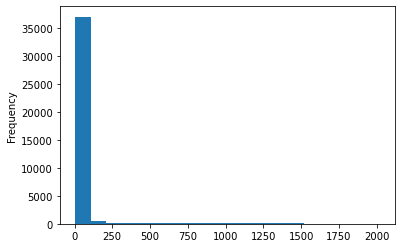

In [865]:
df['cost'].plot(kind='hist', bins=20)

In [866]:
df['cost'].describe()

count    38999.000000
mean        80.972210
std        180.715055
min          5.000000
25%         38.768742
50%         46.468476
75%         70.239797
max       2019.734797
Name: cost, dtype: float64

In [867]:
df['trip'].keys()

RangeIndex(start=0, stop=38999, step=1)

In [868]:
df

,trip,date,dayPart,exWeatherTag,originLocation,destinationLocation,distance,type,weight,packageType,carrier,cost
0,t52712528,2017-09-06,night,NaN,S4,D7,2200,expedited,50,NaN,D,68.413152
1,t29859381,2017-10-21,night,NaN,S8,D1,1800,NaN,12,NaN,B,36.450649
2,t25702332,2017-07-15,night,NaN,S9,D5,2800,NaN,1,NaN,B,9.057939
3,t27713405,2017-10-22,day,NaN,S9,D7,3200,NaN,50,NaN,C,57.320087
4,t49439220,2019-12-11,day,snow,S9,D1,2000,NaN,43,NaN,B,77.263777
...,...,...,...,...,...,...,...,...,...,...,...,...
38994,t11845608590,2019-10-17,night,NaN,S3,D3,1200,NaN,3,NaN,B,14.987239
38995,t53557166488,2019-01-23,night,NaN,S4,D6,2000,NaN,6,NaN,B,33.214738
38996,t337474787136,2018-10-03,night,NaN,S8,D7,3000,NaN,24,NaN,B,45.172159
38997,t76488353326,2018-02-26,night,NaN,S8,D5,2600,NaN,31,NaN,B,47.541427


## Data Engineering

Describe and justify the process for preparing the data for analysis.

Questions to consider:

- Were there variables you dropped or created?
    - Dropped : 'exWeatherTag'
- How did you address missing values or outliers?
- Why are these choices appropriate given the data and the business problem?
- Can you pipeline your preparation steps to use them consistently in the modeling process?

In [869]:
df['exWeatherTag'].unique()

array([nan, 'snow', 'heat'], dtype=object)

In [870]:
df['exWeatherTag'].value_counts()

snow    3286
heat    1596
Name: exWeatherTag, dtype: int64

In [871]:
# converting values in clean_df['exWeatherTag'] into binary
# df.dayPart[df.dayPart == 'Nan'] = 0
# df.dayPart[df.dayPart == 'day'] = 1
# df.dayPart[df.dayPart == 'day'] = 2

In [872]:
# dropping columns
clean_df = df.drop(columns=['exWeatherTag', 'date'])

In [873]:
# code here to prepare your data

In [874]:
# removing 't' from trip column
clean_df['trip'] = clean_df["trip"].str[1:]

In [875]:
# Converting clean_df['date'] into float
# clean_df['date'].apply(lambda x: float(x))

In [876]:
# pd.to_numeric(clean_df['date'], errors='raise')

In [877]:
#clean_df['date'] = pd.to_datetime(df.time_hour)
#df.drop(columns=['year', 'month', 'day', 'hour', 'time_hour'], inplace=True)
#df.head()

In [878]:
# pd.to_datetime(clean_df.time_hour['date'])

In [879]:
#clean_df['month'] = clean_df['date'].dt.month

In [880]:
#clean_df['DOW'] = clean_df['date'].dt.dayofweek

In [881]:
# Turning values in clean_df['dayPart'] to binary
clean_df.dayPart[clean_df.dayPart == 'night'] = 1
clean_df.dayPart[clean_df.dayPart == 'day'] = 0

<ipython-input-881-348d2d4a00eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.dayPart[clean_df.dayPart == 'night'] = 1
<ipython-input-881-348d2d4a00eb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.dayPart[clean_df.dayPart == 'day'] = 0


In [882]:
clean_df['dayPart']

0        1
1        1
2        1
3        0
4        0
        ..
38994    1
38995    1
38996    1
38997    1
38998    1
Name: dayPart, Length: 38999, dtype: object

In [883]:
clean_df['dayPart'].value_counts()

1    25904
0    13095
Name: dayPart, dtype: int64

In [884]:
# amount of values in df['type'] column
clean_df.type.value_counts().expedited

3748

In [885]:
clean_df['type'].unique()

array(['expedited', nan], dtype=object)

In [886]:
clean_df['originLocation'].unique()

array(['S4', 'S8', 'S9', 'S6', 'S7', 'S3', 'S5', 'S1', 'S2'], dtype=object)

In [887]:
clean_df['originLocation'].value_counts()

S3    4461
S5    4388
S6    4379
S8    4368
S4    4324
S1    4312
S9    4302
S7    4267
S2    4198
Name: originLocation, dtype: int64

In [888]:
# Turning values in clean_df['originLocation'] to binary
clean_df.originLocation[clean_df.originLocation == 'S1'] = 1
clean_df.originLocation[clean_df.originLocation == 'S2'] = 2
clean_df.originLocation[clean_df.originLocation == 'S3'] = 3
clean_df.originLocation[clean_df.originLocation == 'S4'] = 4
clean_df.originLocation[clean_df.originLocation == 'S5'] = 5
clean_df.originLocation[clean_df.originLocation == 'S6'] = 6
clean_df.originLocation[clean_df.originLocation == 'S7'] = 7
clean_df.originLocation[clean_df.originLocation == 'S8'] = 8
clean_df.originLocation[clean_df.originLocation == 'S9'] = 9

<ipython-input-888-4f36c573145e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.originLocation[clean_df.originLocation == 'S1'] = 1
<ipython-input-888-4f36c573145e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.originLocation[clean_df.originLocation == 'S2'] = 2
<ipython-input-888-4f36c573145e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.originLocation[clean_df.originLocation == 'S3'] = 3
<ipython-i

In [889]:
clean_df['destinationLocation'].unique()

array(['D7', 'D1', 'D5', 'D4', 'D2', 'D9', 'D6', 'D3', 'D8'], dtype=object)

In [890]:
clean_df['destinationLocation'].value_counts().D7

4297

In [891]:
# Turning values in clean_df['destinationLocation'] to binary
clean_df.destinationLocation[clean_df.destinationLocation == 'D1'] = 1
clean_df.destinationLocation[clean_df.destinationLocation == 'D2'] = 2
clean_df.destinationLocation[clean_df.destinationLocation == 'D3'] = 3
clean_df.destinationLocation[clean_df.destinationLocation == 'D4'] = 4
clean_df.destinationLocation[clean_df.destinationLocation == 'D5'] = 5
clean_df.destinationLocation[clean_df.destinationLocation == 'D6'] = 6
clean_df.destinationLocation[clean_df.destinationLocation == 'D7'] = 7
clean_df.destinationLocation[clean_df.destinationLocation == 'D8'] = 8
clean_df.destinationLocation[clean_df.destinationLocation == 'D9'] = 9

<ipython-input-891-ba9753200eac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.destinationLocation[clean_df.destinationLocation == 'D1'] = 1
<ipython-input-891-ba9753200eac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.destinationLocation[clean_df.destinationLocation == 'D2'] = 2
<ipython-input-891-ba9753200eac>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.destinationLocation[clean_df.destinationLo

In [892]:
clean_df['type'].unique()

array(['expedited', nan], dtype=object)

In [893]:
# Turning values in clean_df['type'] to binary
clean_df.type[clean_df.type == 'nan'] = 0
clean_df.type[clean_df.type == 'expedited'] = 1

<ipython-input-893-1ca7a4560a03>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.type[clean_df.type == 'nan'] = 0
<ipython-input-893-1ca7a4560a03>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.type[clean_df.type == 'expedited'] = 1


In [894]:
clean_df['packageType'].unique()

array([nan, 'TT'], dtype=object)

In [905]:
# Turning values in clean_df['packageType'] to binary
clean_df.packageType[clean_df.packageType == 'nan'] = 0
clean_df.packageType[clean_df.packageType == 'TT'] = 1

<ipython-input-905-0c6c52cc0296>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.packageType[clean_df.packageType == 'nan'] = 0
<ipython-input-905-0c6c52cc0296>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.packageType[clean_df.packageType == 'TT'] = 1


In [909]:
clean_df['carrier'].unique()

array(['D', 'B', 'C', 'A'], dtype=object)

In [910]:
# Turning values in clean_df['carrier'] to binary
clean_df.carrier[clean_df.carrier == 'A'] = 0
clean_df.carrier[clean_df.carrier == 'B'] = 1
clean_df.carrier[clean_df.carrier == 'C'] = 2
clean_df.carrier[clean_df.carrier == 'D'] = 3

<ipython-input-910-5cc71f479bdf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.carrier[clean_df.carrier == 'A'] = 0
<ipython-input-910-5cc71f479bdf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.carrier[clean_df.carrier == 'B'] = 1
<ipython-input-910-5cc71f479bdf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.carrier[clean_df.carrier == 'C'] = 2
<ipython-input-910-5cc71f479bdf>:5: SettingWithCopyWarn

### Train test split

In [914]:
X = clean_df.drop(columns='cost')
y = clean_df['cost']

In [915]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [916]:
# Scaling, fitting, and transforming train and test data 
scaler = StandardScaler()
scaler.fit(X_train)

X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [921]:
#Exploring target column breakdown
len(y_train.value_counts())

3456

In [941]:
y_train.head()

2878     1562.747197
22628      43.776146
348        36.450649
4847       69.589504
19735      28.535654
Name: cost, dtype: float64

## Exploring relationship between two variables

In [930]:
clean_df.head()

,trip,dayPart,originLocation,destinationLocation,distance,type,weight,packageType,carrier,cost
0,52712528,1,4,7,2200,1,50,NaN,3,68.413152
1,29859381,1,8,1,1800,NaN,12,NaN,1,36.450649
2,25702332,1,9,5,2800,NaN,1,NaN,1,9.057939
3,27713405,0,9,7,3200,NaN,50,NaN,2,57.320087
4,49439220,0,9,1,2000,NaN,43,NaN,1,77.263777


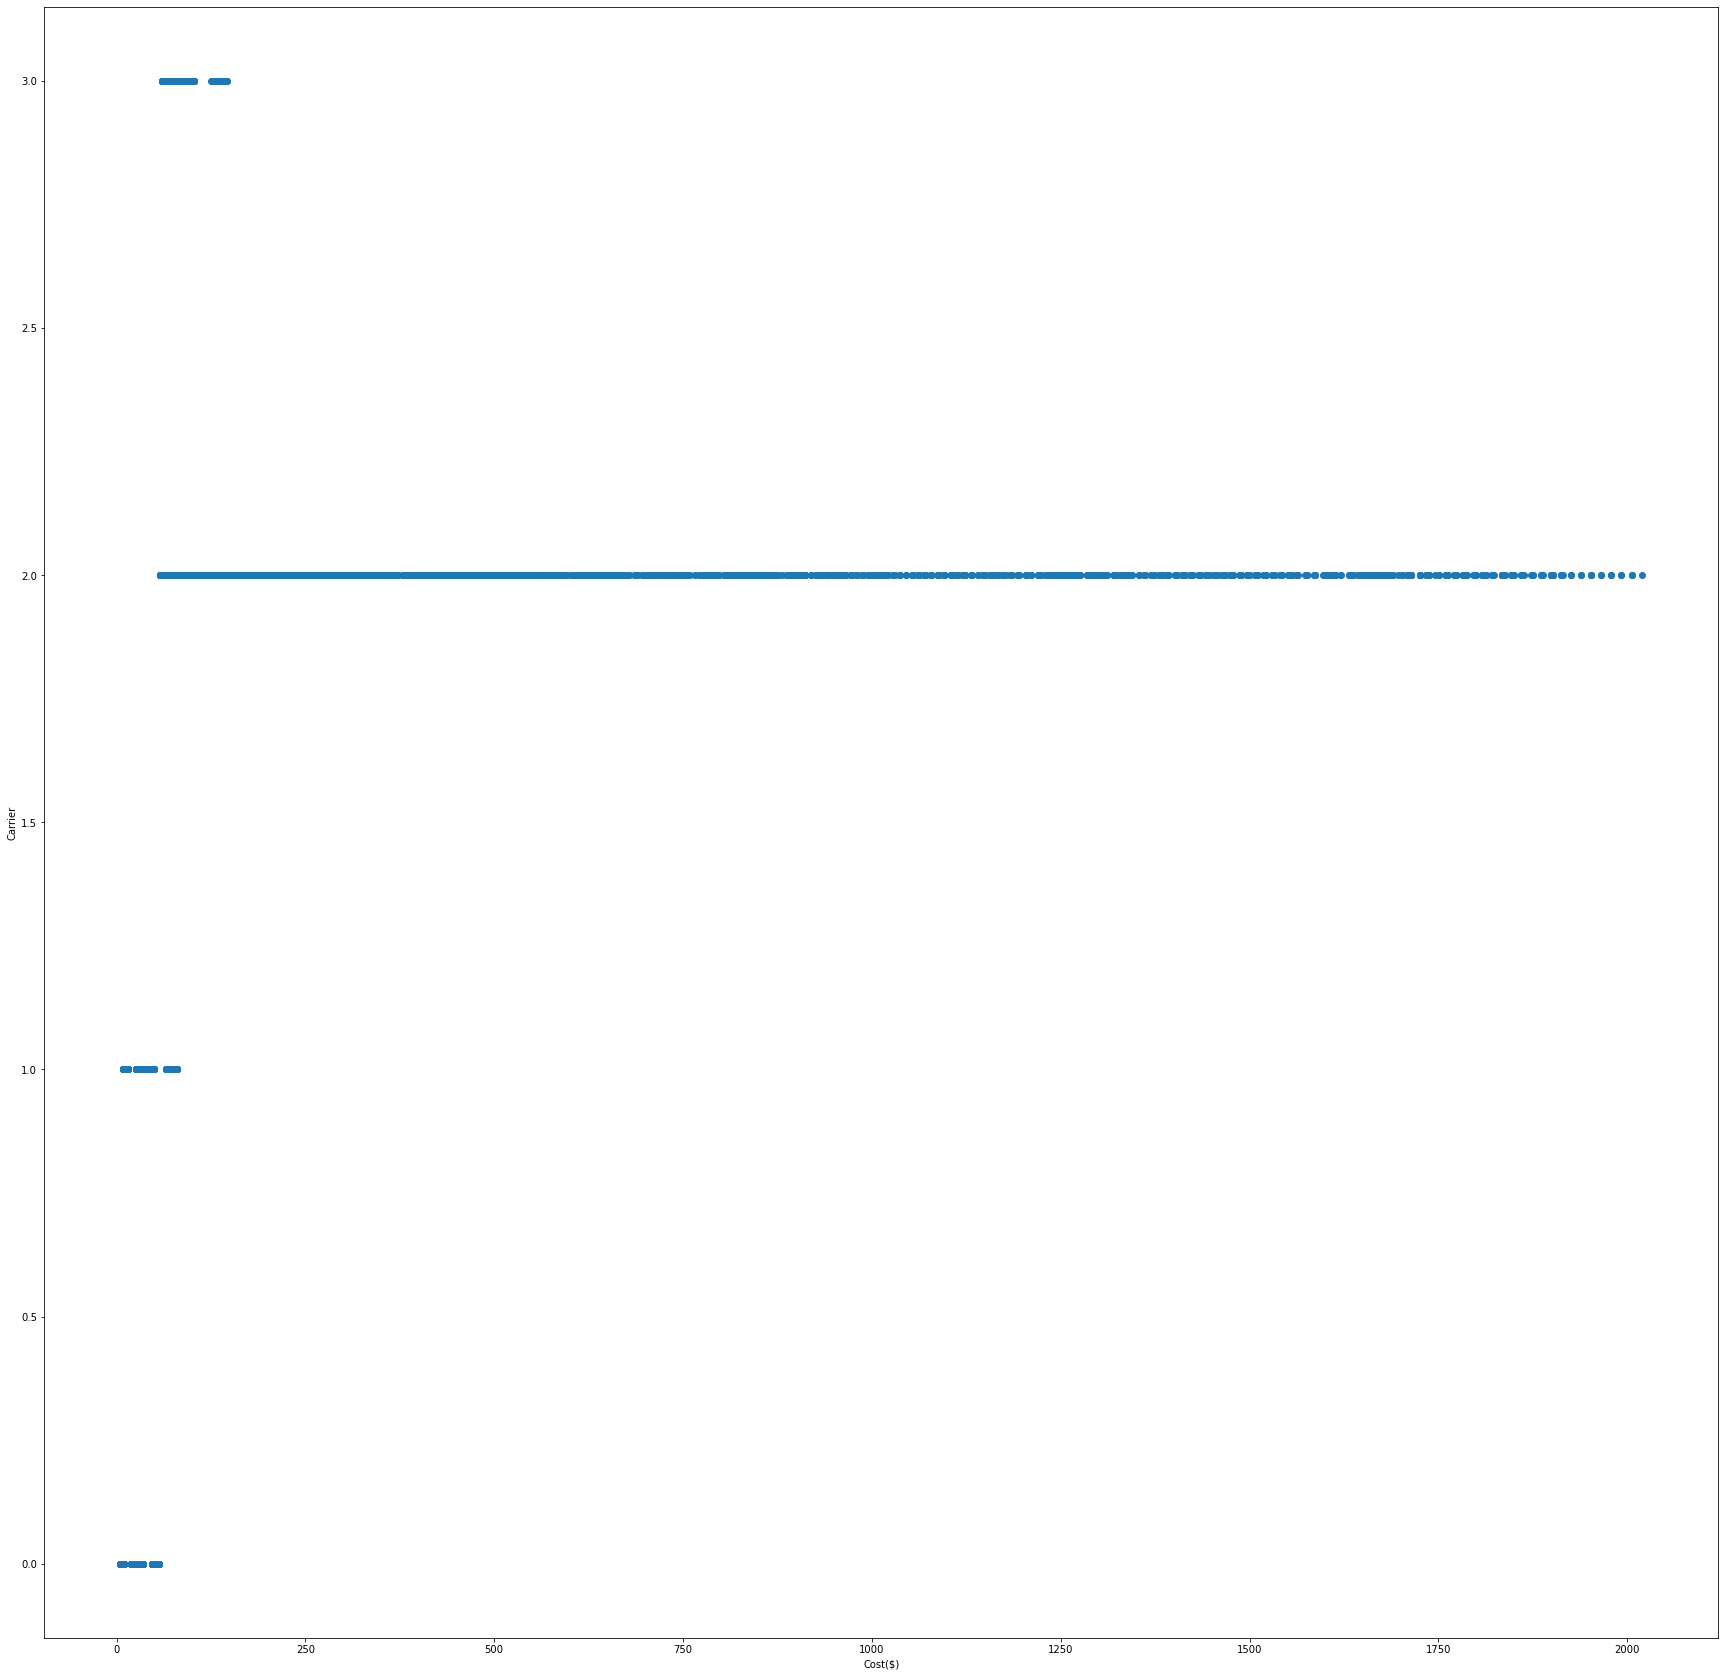

In [940]:
# can use a scatter plot to explore relationship between 2 variables
plt.figure(figsize=(30,30))

plt.scatter(clean_df['cost'], clean_df['carrier'])
plt.ylabel('Carrier')
plt.xlabel('Cost($)')
plt.show()

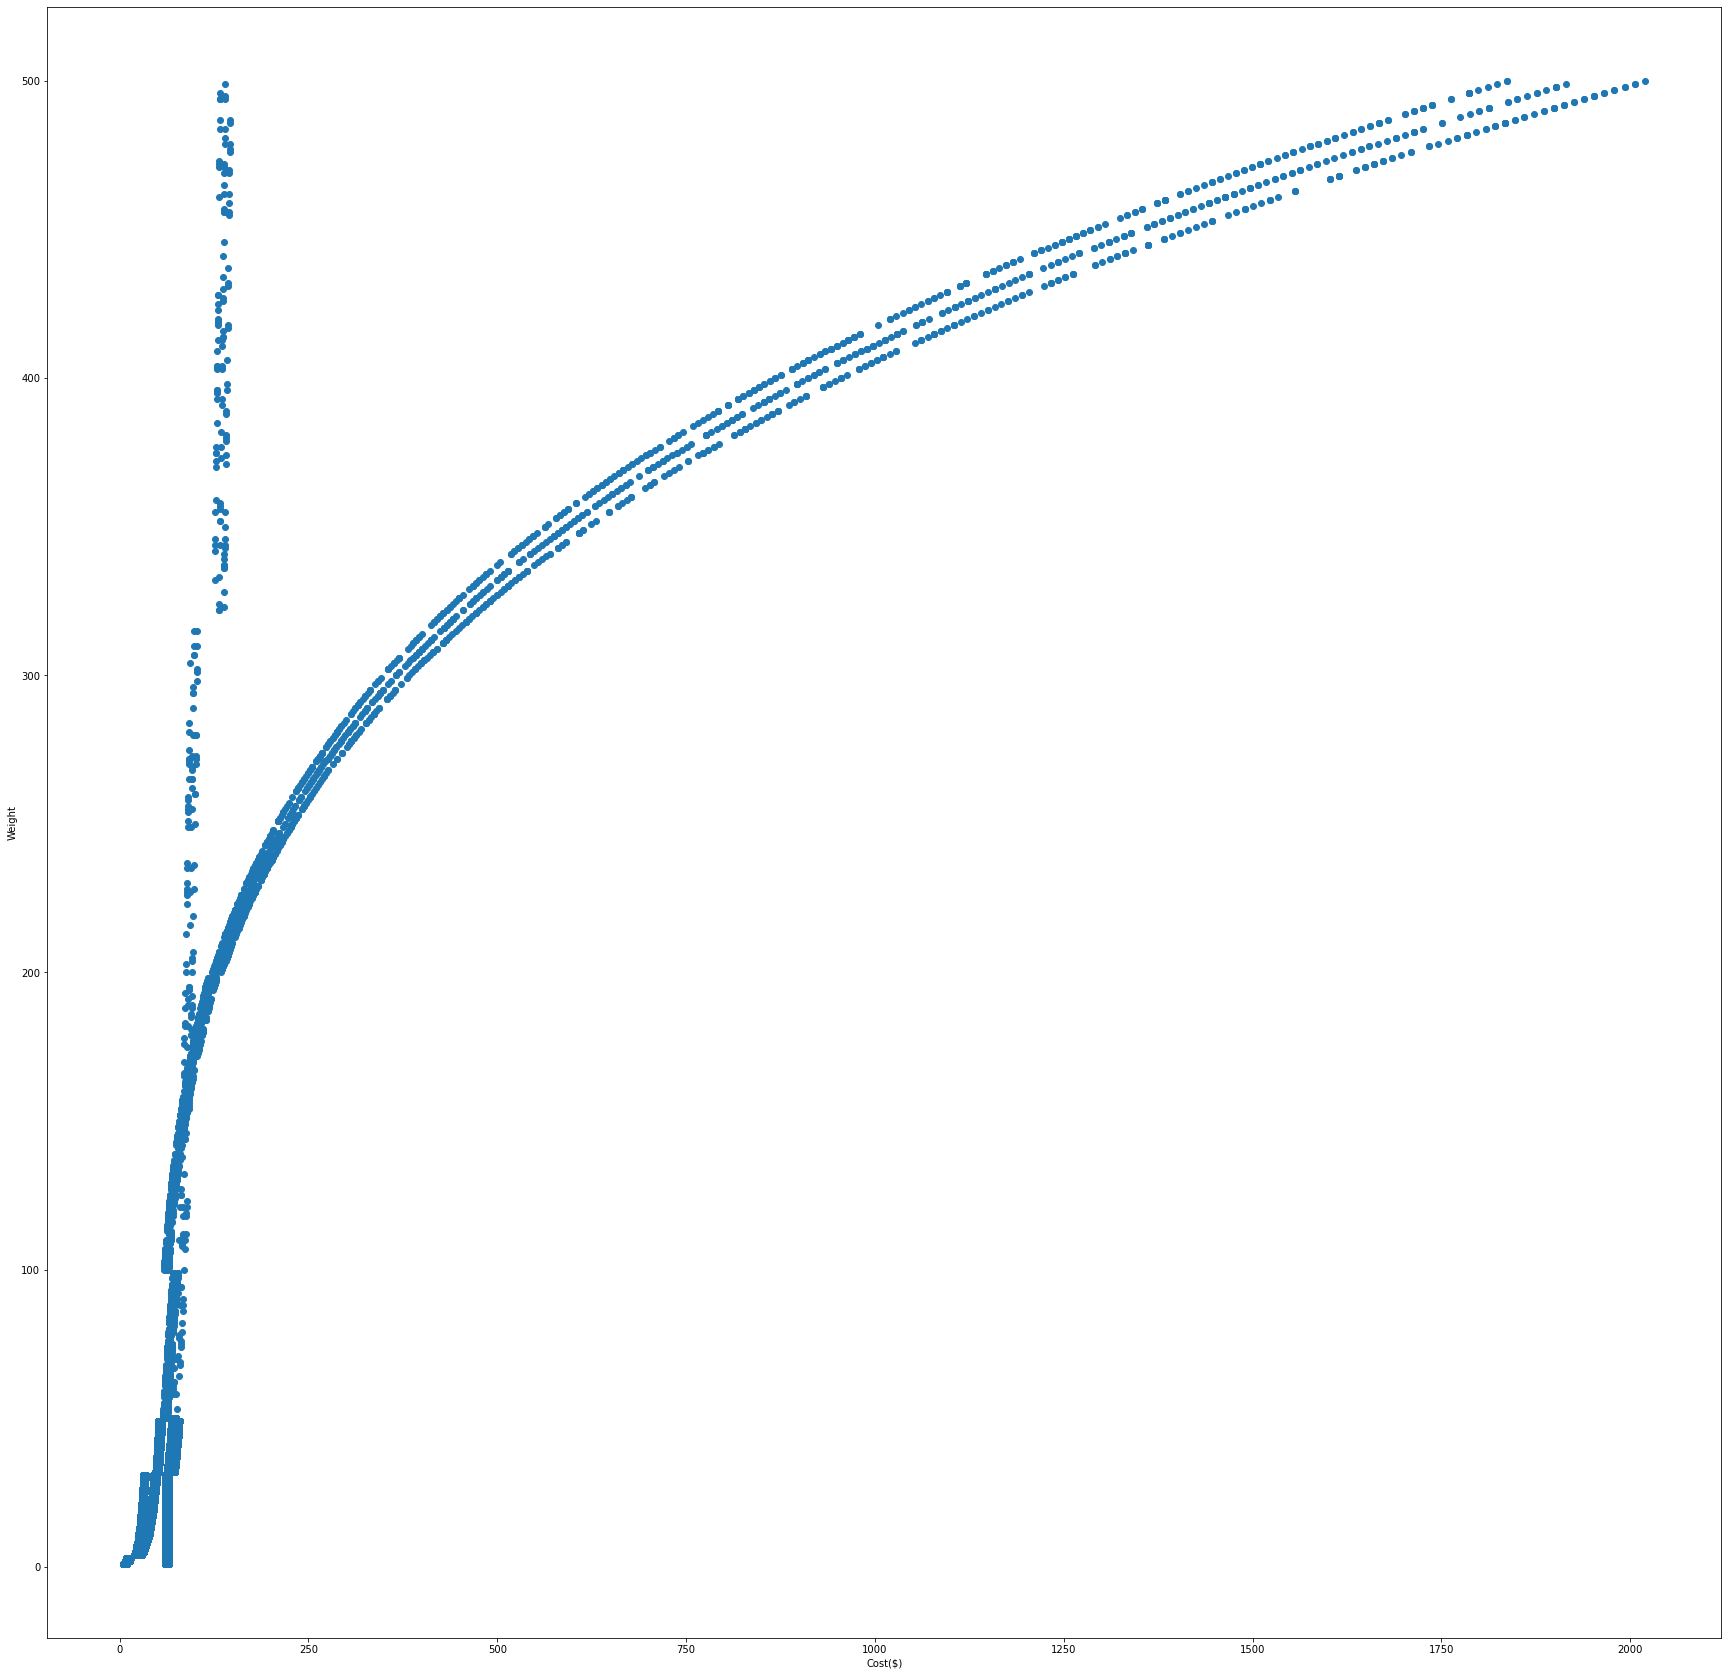

In [939]:
# can use a scatter plot to explore relationship between 2 variables
plt.figure(figsize=(30,30))

plt.scatter(clean_df['cost'], clean_df['weight'])
plt.ylabel('Weight')
plt.xlabel('Cost($)')
plt.show()

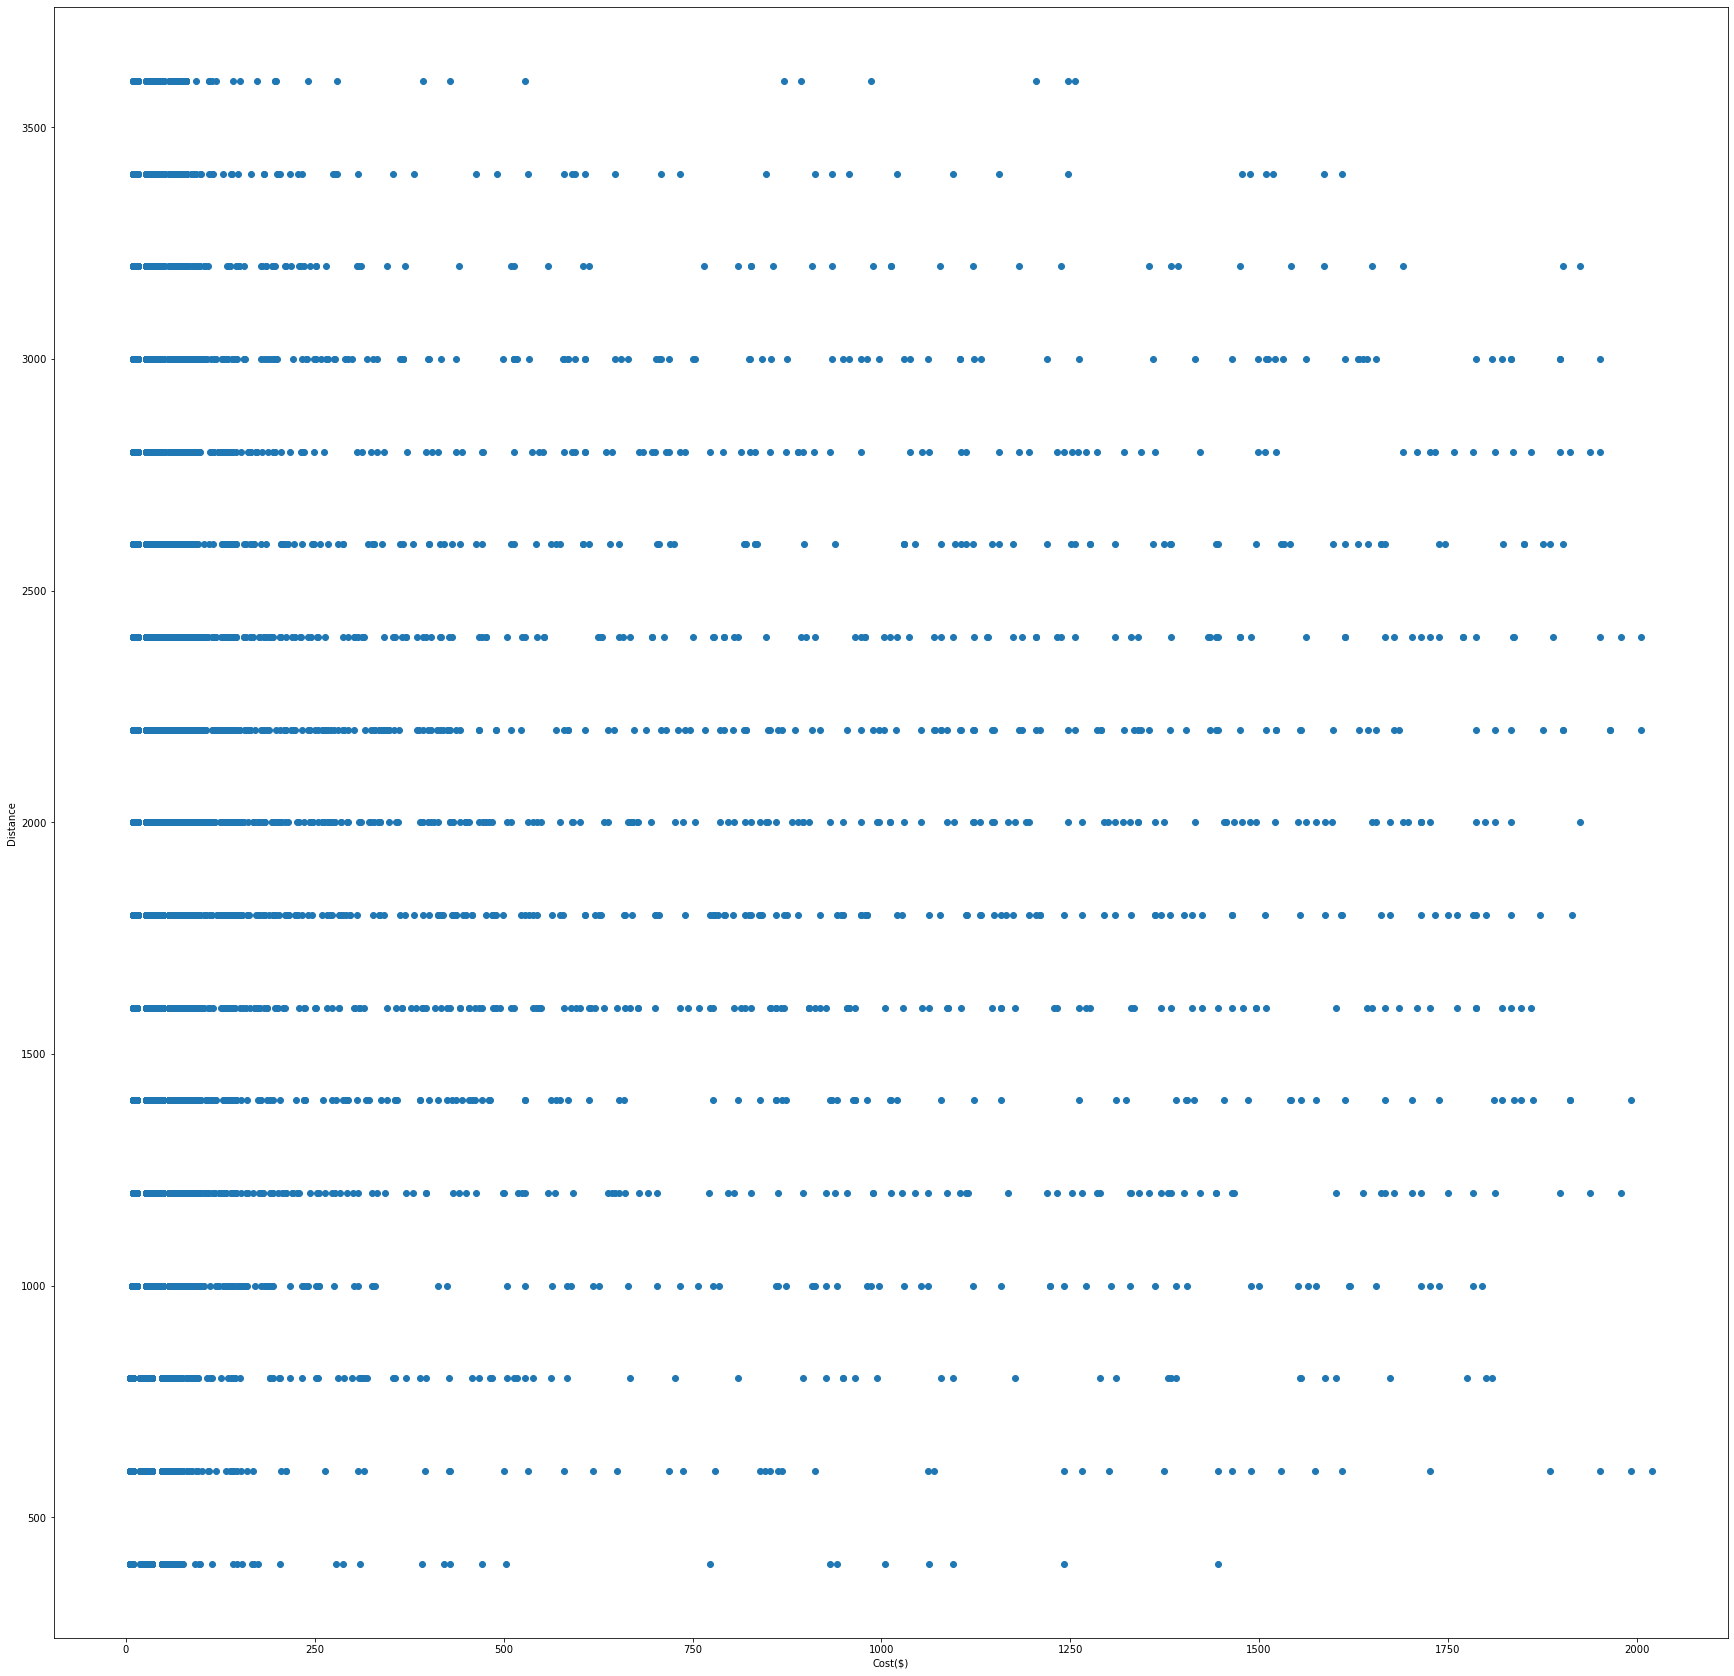

In [938]:
# can use a scatter plot to explore relationship between 2 variables
plt.figure(figsize=(30,30))

plt.scatter(clean_df['cost'], clean_df['distance'])
plt.ylabel('Distance')
plt.xlabel('Cost($)')
plt.show()

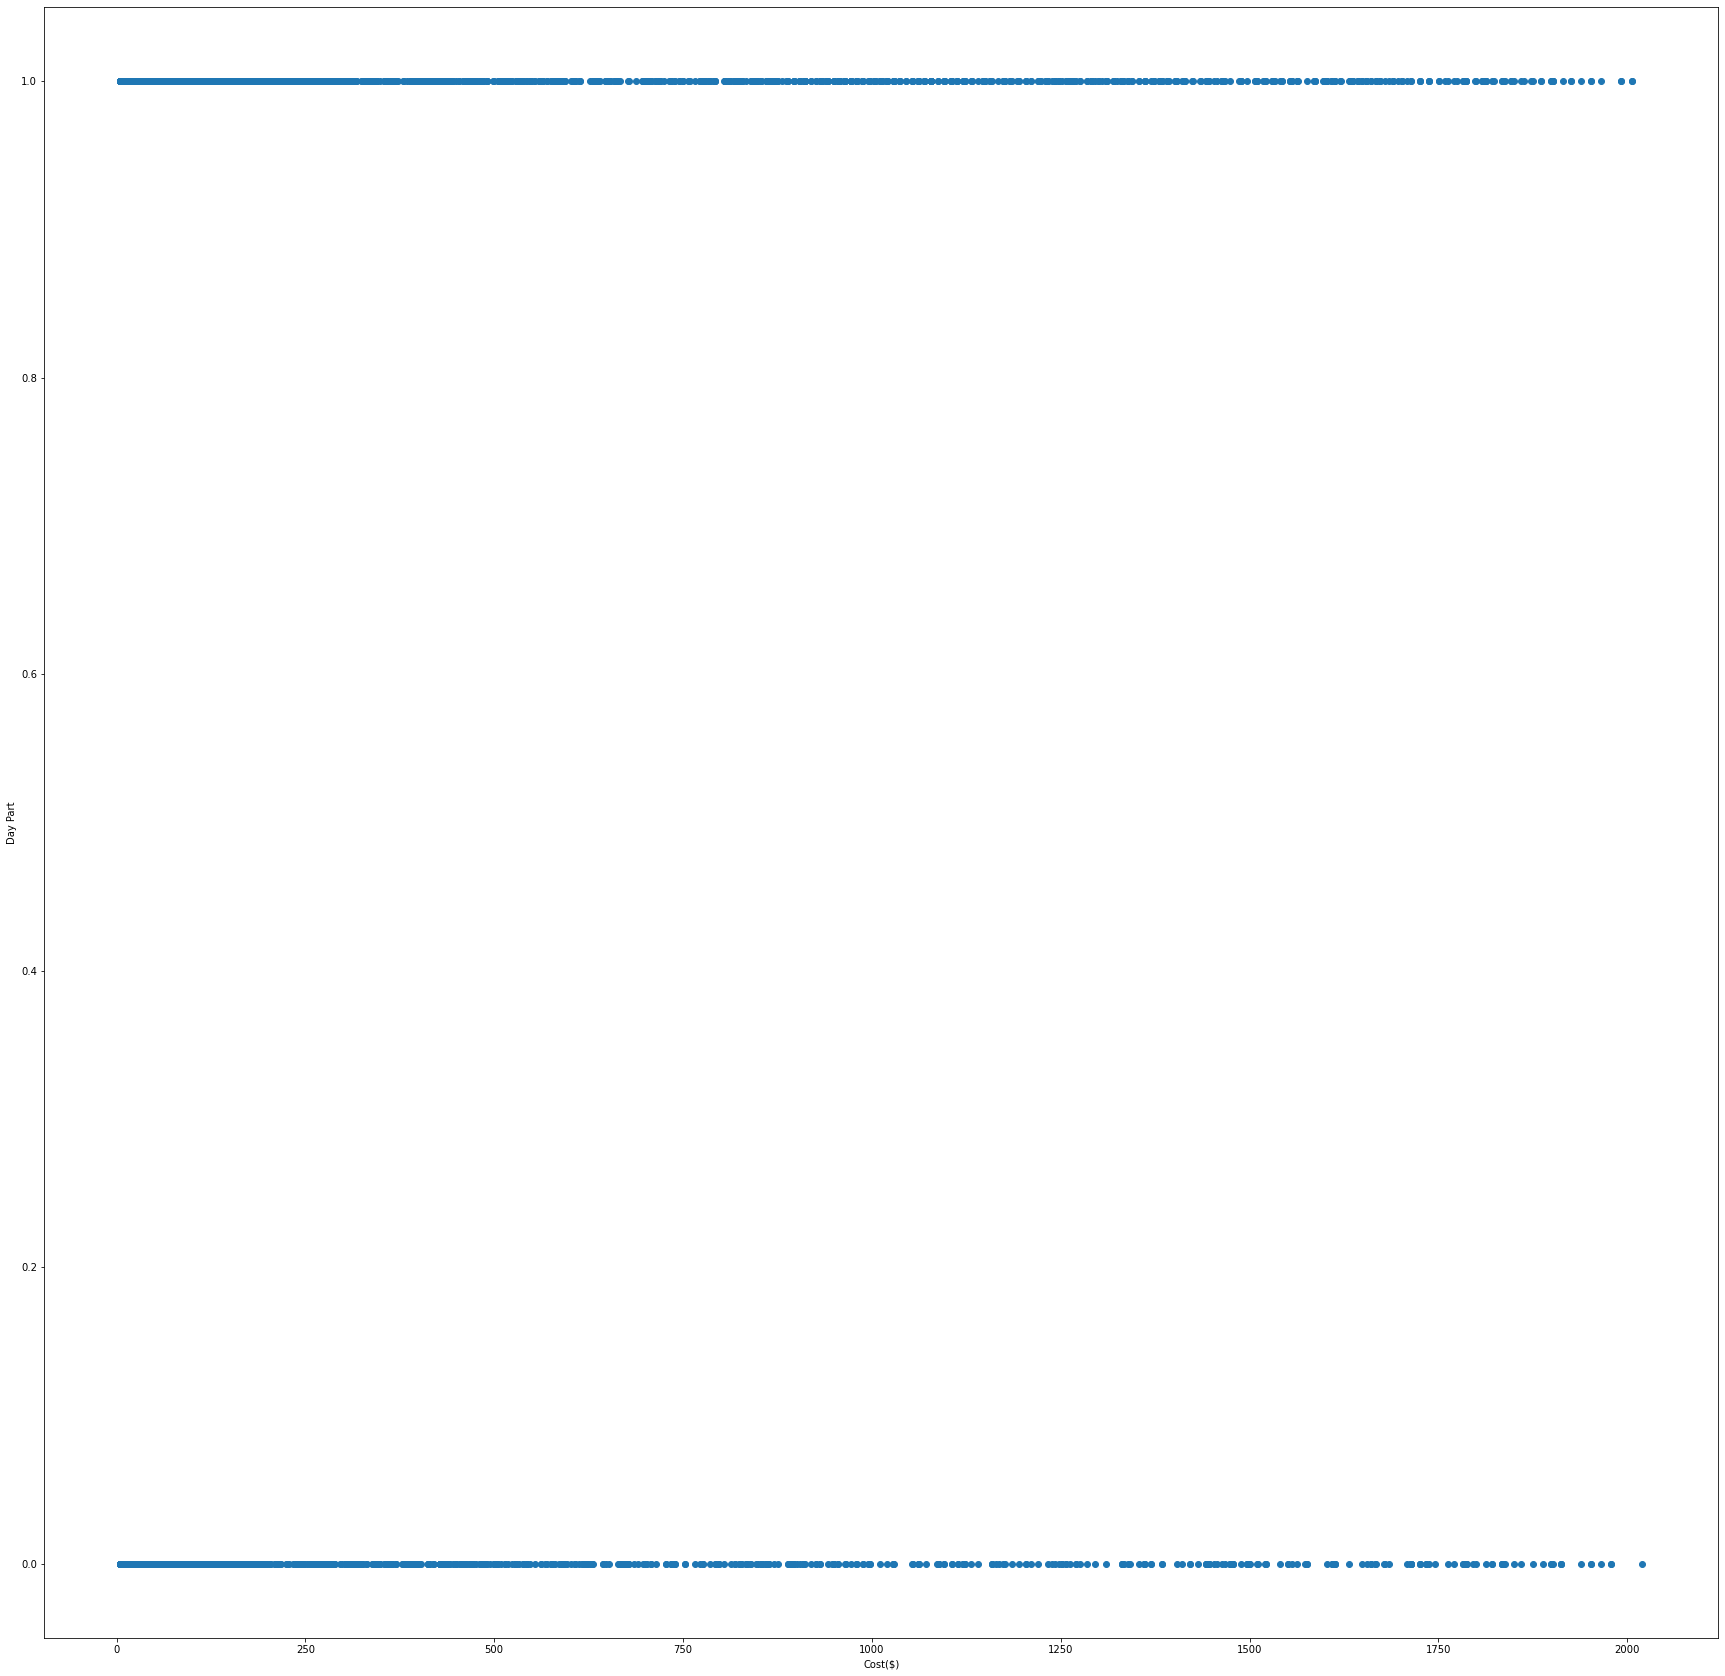

In [935]:
# can use a scatter plot to explore relationship between 2 variables
plt.figure(figsize=(30,30))

plt.scatter(clean_df['cost'], clean_df['dayPart'])
plt.ylabel('Day Part')
plt.xlabel('Cost($)')
plt.show()

## Modeling

Describe and justify the process for analyzing or modeling the data.

Questions to consider:

- How will you analyze the data to arrive at an initial approach?
- How will you iterate on your initial approach to make it better?
- What model type is most appropriate, given the data and the business problem?

## Evaluation

The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem.

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
- How well does your model/data fit any relevant modeling assumptions?
- For the final model, you might also consider:

- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?
- What does this final model tell you about the relationship between your inputs and outputs?

### Baseline Understanding 

What does a baseline, model-less prediction look like?

In [ ]:
# code here to arrive at a baseline prediction

### First ___ Model

Before going too far down the data preparation rabbit hole, be sure to check your work against a first 'substandard' model! What is the easiest way for you to find out how hard your problem is?

In [ ]:
# code here for your first 'substandard' model

In [ ]:
# code here to evaluate your first 'substandard' model

### Explore Model Types 

Explore more model types, using fundamentally different algorithms to see how well they fit the data.

For example, if you chose to run a decision tree as your first ___ model, you may try a linear/logistic regression
next to see how it performs.

In [ ]:
# code here for a different model type

In [ ]:
# code here to evaluate that different model

### Model Choice & Modeling Iterations

Choose which underlying type of model works best, given your initial modeling and your understanding of the data/business problem. This might boil down to deciding whether tree-based or linear model would work best. After making this choice, focus only on models within that family of models (for example, if tree-based models work well and make sense in context, could explore random forests next).

Now you can start to use the results of your first model to iterate - there are many options! Explore hyperparameters and feature selection/feature engineering!

In [ ]:
# code here to iteratively improve your models

In [ ]:
# code here to evaluate your iterations

### 'Final' Model

In the end, you'll arrive at a 'final' model - aka the one you'll use to make your recommendations/conclusions. This likely blends any group work. It might not be the one with the highest scores, but instead might be considered 'final' or 'best' for other reasons.

In [ ]:
# code here to show your final model

In [ ]:
# code here to evaluate your final model

## Conclusion

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- How could the stakeholder use your model effectively?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?